# Import libs

In [1]:
import pandas as pd
import numpy as np
import re
import requests
import folium
import time
from geopy.geocoders import *
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Functions 

In [2]:
def clean_column_names(df):
    """
    Clean column names by converting to lowercase, replacing spaces and special characters with underscores,
    and replacing multiple underscores with a single underscore.

    Parameters:
    - df: pandas DataFrame

    Returns:
    - Cleaned DataFrame with modified column names
    """
    # Define a function to replace spaces and special characters with underscores
    def clean_name(name):
        return re.sub(r'[^a-zA-Z0-9_]+', '_', name.lower())

    df.columns = [clean_name(col) for col in df.columns]
    return df

def geocode_GoogleMaps(df, column_name):
    """
    Geocode addresses using Google Maps API.

    Parameters:
    df (DataFrame): Input DataFrame containing address data.
    column_name (str): Name of the column with addresses to geocode.

    Returns:
    DataFrame: DataFrame with added latitude, longitude, formatted_address, location_type, types_1, types_2, and source columns.
    """
    from geopy.geocoders import GoogleV3
    
    # Copy df
    df=df.copy()
    
    # Create the locator
    geolocator = GoogleV3(api_key="xxx",user_agent="Google",timeout=None)

    
    for i, row in df.iterrows():
        # the geopy GoogleV3 geocoding call
        location = geolocator.geocode(row[column_name]
                                      #,components=component_restrictions
                                     )
        if location:
            print("Extraction: ", location)
            df.loc[i, 'latitude'] = location.latitude
            df.loc[i, 'longitude'] = location.longitude
            df.loc[i, 'formatted_address'] = location.raw.get('formatted_address', '')
            df.loc[i, 'location_type'] = location.raw.get('geometry', {}).get('location_type', '')
            
            # Safely access types[0] and types[1]
            types = location.raw.get('types', [])
            df.loc[i, 'types_1'] = types[0] if len(types) > 0 else ''
            df.loc[i, 'types_2'] = types[1] if len(types) > 1 else ''
    
            df.loc[i, 'source'] = "Google maps"
            
    return df

# Load and Clean Security incident data

This cell loads an Excel file containing security incident data, normalizes the column names, and displays the first few rows of the DataFrame.


In [16]:
# Replace 'your_file_path.xlsx' with the actual path to your Excel file
file_path = r'.\incident_description.xlsx'
sheet_name = 'security_incident'

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(file_path, 
                   sheet_name=sheet_name,
                  header=0)

# normalize columns
df = clean_column_names(df)

# Print the incidents
for i in df['incident'] :
    print(i,'\n')
    
# Display the DataFrame
df

After the ELN (National Liberation Army) ambushed a military patrol on November 2, 2023, in the rural area of Catatumbo, killing 14 soldiers and wounding 7 others, the Colombian government declared a state of emergency in the region. The attack led to intensified military operations, including aerial bombardments and ground offensives in the jungle and mountainous areas of Catatumbo. By December 15, the conflict had led to the displacement of thousands of civilians, with numerous reports of infrastructure destruction and severe shortages of food and medical supplies. 

On April 15, 2023, armed clashes erupted between the Sudanese Armed Forces (SAF) and the Rapid Support Forces (RSF) in Arkaweet neighbourhood in Khartoum, resulting in the deaths of over 500 civilians and the injury of hundreds more. The Sudanese government declared a state of emergency and imposed a curfew. The conflict quickly spread to other regions, leading to large-scale displacement and a humanitarian crisis. By Ju

id                                           incident
0   1  After the ELN (National Liberation Army) ambus...
1   2  On April 15, 2023, armed clashes erupted betwe...
2   3  After the October 7, 2023, attack by Hamas and...
3   4  Following the military coup in Myanmar on Febr...

# LLM 

## Query the LLM via curl to LM Studio

This cell sends incident descriptions to a local language model for extracting location information, orders it from the most precise to the least precise, and stores the results in the DataFrame. The model is hosted on [LLM Studio](https://lmstudio.ai/) in local server mode, which allows for privacy, easy testing and switching between multiple models.

Model tested with great performance on a local machine (Nvidia T1200 4Go):

- [Phi-3-mini-128k-instruct-GGUF-Imatrix-smashed](https://huggingface.co/PrunaAI/Phi-3-mini-128k-instruct-GGUF-Imatrix-smashed)
- [OpenHermes-2.5-Mistral-7B-GGUF](https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF)

The prompt is something like :
"Extract the locations information of the incident and list them separated by comma, starting with the country (infere it if needed), to be ready for geocoding. The answer should be the location string only!. If there is multiple location, list each one by row. Here is the text :"


In [8]:
%%time

# URL to LM Studio
url = 'http://localhost:1234/v1/chat/completions'
headers = {'Content-Type': 'application/json'}

# Parameters
system_message = {"role": "system", 
                  "content": "Prepare location information for geocoding, order from the most precise to the least precise."}
task = "Extract the locations information of the incident and list them separated by comma, starting with the country (infere it if needed), to be ready for geocoding. The answer should be the location string only!. If there is multiple location, list each one by row. Here is the text :"
temperature = 0.1 # The lower, the less inventive
max_tokens = 50 # Max number of output tokens
stream = False  #if true, the server will stream token by token

for index, row in df.iterrows():
    # track time
    iter_start = time.time()

    description = row['incident']

    # Handle if there is no description or too short
    if pd.isna(description) or len(description) < 5 :
        # Calculate the duration
        iter_stop = time.time()
        iter_duration_seconds = iter_stop - iter_start
        print(f"ID-{index} in {round(iter_duration_seconds)} sec - Empty description",)
        continue
    
    # Create the user message with the description
    user_message = {"role": "user", "content": task + description}
    
    # Include the user message in the data payload
    data = {
        "messages": [system_message, user_message],
        "temperature": temperature,
        "max_tokens": max_tokens,
        "stream": stream
    }

    #print(f"ID-{index} : Sending request...",)
    # Send the request
    response = requests.post(url, headers=headers, json=data)
    
    # Extract and store the result in the 'description_result' column
    result_content = response.json()['choices'][0]['message']['content']
    

    # Store the extracted information in the DataFrame
    df.at[index, 'llm_raw'] = result_content

    # Calculate the duration
    iter_stop = time.time()
    iter_duration_seconds = iter_stop - iter_start

    print(f"ID-{index} in {round(iter_duration_seconds)} sec - ANSWER:\n{result_content}\n",)

# Display the DataFrame
df

ID-0 in 17 sec - ANSWER:
 Colombia, Catatumbo

ID-1 in 17 sec - ANSWER:
 Sudan, Khartoum, Arkaweet neighbourhood

ID-2 in 15 sec - ANSWER:
 Israel, Gaza Strip, Al Mawasi

ID-3 in 17 sec - ANSWER:
 Myanmar, Yangon, Mandalay

CPU times: total: 15.6 ms
Wall time: 1min 5s


id                                           incident  \
0   1  After the ELN (National Liberation Army) ambus...   
1   2  On April 15, 2023, armed clashes erupted betwe...   
2   3  After the October 7, 2023, attack by Hamas and...   
3   4  Following the military coup in Myanmar on Febr...   

                                    llm_raw  
0                       Colombia, Catatumbo  
1   Sudan, Khartoum, Arkaweet neighbourhood  
2             Israel, Gaza Strip, Al Mawasi  
3                 Myanmar, Yangon, Mandalay

## Analyze the answers
The extraction is not 100% correct. For example, the Gaza Strip is shown as being in Israel, even though it is Palestinian territory. 

The intelligence of the LLM plays a part in the extraction and correction of the localisation. Here is an example with the local LLM and another with ChatGpt-4o

**With Local LLM Phi-3-mini-128k-instruct-GGUF-Imatrix-smashed**
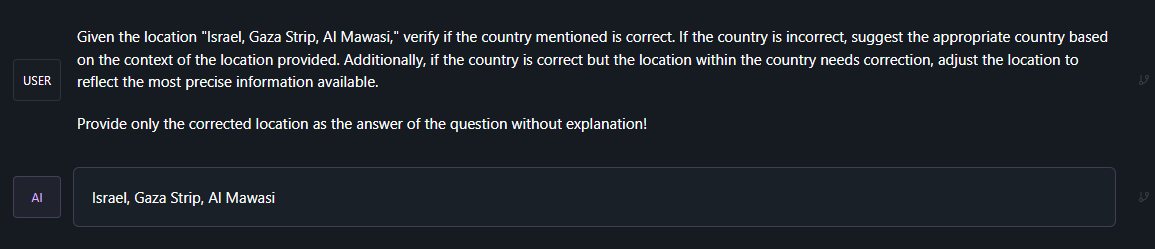

**With Chat-Gpt-4o**

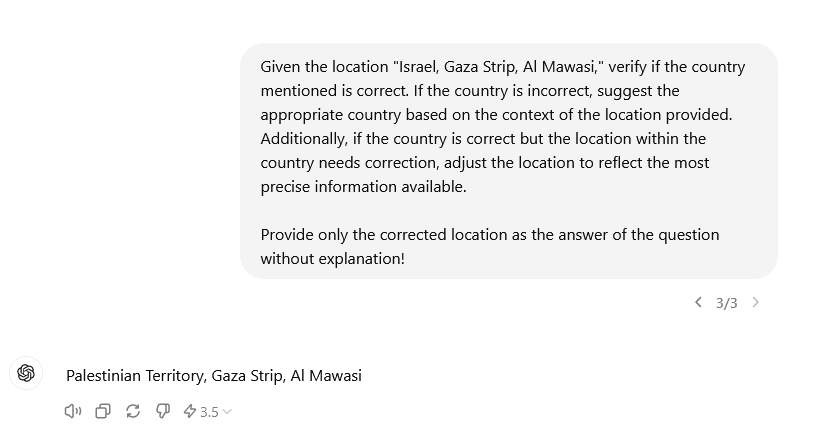

In our case the geocoding phase will correct the situation.

# Geocode Location Information Using Google Maps

This cell geocodes the extracted location information using Google Maps and stores the results in a new DataFrame.

We can see the Gaza Strip case beeing solved and have a correct location.

In [5]:
df_output = geocode_GoogleMaps(df, 'llm_raw')
df_output

Extraction:  Catatumbo Region, Norte de Santander, Colombia
Extraction:  Arkaweet, Khartoum, Sudan
Extraction:  Al Mawasi
Extraction:  Mandalay, Yangon, Myanmar (Burma)


id                                           incident  \
0   1  After the ELN (National Liberation Army) ambus...   
1   2  On April 15, 2023, armed clashes erupted betwe...   
2   3  After the October 7, 2023, attack by Hamas and...   
3   4  Following the military coup in Myanmar on Febr...   

                                    llm_raw   latitude  longitude  \
0                       Colombia, Catatumbo   8.577582 -73.094101   
1   Sudan, Khartoum, Arkaweet neighbourhood  15.548134  32.568383   
2             Israel, Gaza Strip, Al Mawasi  31.348415  34.256136   
3                 Myanmar, Yangon, Mandalay  16.947457  96.064749   

                                formatted_address     location_type  \
0  Catatumbo Region, Norte de Santander, Colombia       APPROXIMATE   
1                       Arkaweet, Khartoum, Sudan       APPROXIMATE   
2                                       Al Mawasi       APPROXIMATE   
3               Mandalay, Yangon, Myanmar (Burma)  GEOMETRIC_CENTER   

           types_1      types_2       source  
0  colloquial_area    political  Google maps  
1        political  sublocality  Google maps  
2         locality    political  Google maps  
3            route               Google maps

# Visualize Geocoded Locations on a Map

This cell creates a map with OSM background and adds the points representing the geocoded locations with popups containing extracted information from the LLM.

In [15]:
# Create a map centered at an initial location
m = folium.Map(location=[df_output['latitude'].mean(), df_output['longitude'].mean()], zoom_start=2)

# Add points to the map with popups
for idx, row in df_output.iterrows():
    popup_text = row['llm_raw']  # Extract popup text from the 'llm_raw' column
    folium.Marker([row['latitude'], row['longitude']], popup=popup_text).add_to(m)

m

# Export to CSV

In [7]:
# Specify the file path
excel_file_path = r'.\incident_description_output.xlsx'

# Export the DataFrame to an Excel file
df_output.to_excel(excel_file_path, index=False)